In [2]:
"""
Created on Mon Mar 25 18:00:45 2019

@author: luisgranados
"""
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

house_source_data = pd.read_csv("train.csv")
house_test = pd.read_csv("test.csv")

# A function to calculate Root Mean Squared Logarithmic Error (RMSLE).
from sklearn.metrics import mean_squared_log_error

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

# Stage the ratings for the mapper function.
# Remember, these are ordinal features.
qual_rating_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual',
                'GarageCond', 'PoolQC']

qual_ordinal_ratings = [
        ('Ex',5), 
        ('Gd',4), 
        ('TA',3), 
        ('Fa',2), 
        ('Po',1), 
        ('NA',0)
    ]

# Exposure features need own mapping.
exposure_rating_feature = ['BsmtExposure']
exposure_ordinal_ratings = [
        ('Gd',4), 
        ('Av',3), 
        ('Mn',2), 
        ('No',1), 
        ('NA',0)
    ]

electrical_rating_feature = ['Electrical']
electrical_ordinal_ratings = [
        ('SBrkr',5),
        ('FuseA',4),
        ('FuseF',3),
        ('FuseP',2),
        ('Mix',1)
    ]

functional_rating_feature = ['Functional']
functional_ordinal_ratings = [
        ('Typ',7), 
        ('Min1',6), 
        ('Min2',5), 
        ('Mod',4), 
        ('Maj1',3),
        ('Maj2',2),
        ('Sev',1),
        ('Sal',0)
    ]

# Finish ratings
bsmt_finish_rating_features = ['BsmtFinType1', 'BsmtFinType2']
bsmtfin_ordinal_ratings = [
        ('GLQ',6), 
        ('ALQ',5), 
        ('BLQ',4), 
        ('Rec',3), 
        ('LwQ',2),
        ('Unf',1),
        ('NA',0)
    ]

grg_finish_rating_feature = ['GarageFinish']
grgfin_ordinal_ratings = [
        ('Fin',3), 
        ('RFn',2), 
        ('Unf',1), 
        ('NA',0)
    ]

paved_rating_feature = ['PavedDrive']
paved_ordinal_ratings = [
        ('Y',2), 
        ('P',1), 
        ('N',0)
    ]

fence_rating_feature = ['Fence']
fence_ordinal_ratings = [
        ('GdPrv',4),
        ('MnPrv',3),
        ('GdWo',2), 
        ('MnWw',1),
        ('NA',0)
    ]

alley_rating_feature = ['Alley']
alley_ordinal_ratings = [
        ('Pave',2),
        ('Grvl',1),
        ('NA',0)
    ]

utilities_rating_feature = ['Utilities']
utilities_ordinal_ratings = [
        ('AllPub',3),
        ('NoSewr',2),
        ('NoSeWa',1),
        ('ELO', 0)
    ]

# Select categorical features to one-hot-encode.
categorial_onehot_features = ['MSZoning',
    'Street',
    'LotShape',
    'LandContour',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'CentralAir',
    'GarageType',
    'SaleType',
    'SaleCondition'
    ]

selected_categorical_onehot = [
    'YrSold',
    'MoSold',
    'MSZoning',
    'Street',
    #'LandContour',
    #'LotConfig',
    #'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    #'BldgType', # might still keep this one
    'HouseStyle',
    'RoofStyle',
    #'RoofMatl',
    'Exterior1st',
    #'Exterior2nd', #might keep this
    #'MasVnrType',
    #'Heating',
    'CentralAir',
    'GarageType',
    'SaleType',
    'SaleCondition'      
]

# Use this function for generating new ones. I can't generalize this part 
# because of all the potentially different ways to create each feature.
# but this will allow me to do the same generation for the test set.
def generator(dataframe):
    """Generate new features."""
    new_dataframe = dataframe.copy()
    
    new_dataframe['yard_size'] = new_dataframe['LotArea'] - (new_dataframe['1stFlrSF'] + new_dataframe['GarageArea'])
    
    new_dataframe['yard_size_sqrd'] = new_dataframe['yard_size']**2
    
    new_dataframe['yard_size_cubed'] = new_dataframe['yard_size']**3
    
    new_dataframe['YearBuilt_sqrd'] = new_dataframe['YearBuilt']**2
    
    new_dataframe['YearBuilt_cubed'] = new_dataframe['YearBuilt']**3
    
    new_dataframe['total_sqft'] = (new_dataframe['2ndFlrSF'] + new_dataframe['TotalBsmtSF'] + 
                                   new_dataframe['1stFlrSF'] + new_dataframe['GarageArea'])
    
    new_dataframe['total_house_sqft'] = (new_dataframe['2ndFlrSF'] + new_dataframe['TotalBsmtSF'] + 
                                   new_dataframe['1stFlrSF'])
    
    new_dataframe['total_bathrooms'] = (new_dataframe['FullBath'] + (0.5 * new_dataframe['HalfBath']) +
                               new_dataframe['BsmtFullBath'] + (0.5 * new_dataframe['BsmtHalfBath']))
    
    new_dataframe['liv_area_interaction'] = new_dataframe['GrLivArea'] * new_dataframe['total_sqft']
    
    new_dataframe['housesqft_qual_inter'] = new_dataframe['total_sqft'] * new_dataframe['OverallQual']
    
    new_dataframe['OverallCond_Qual_inter'] = new_dataframe['OverallCond'] * new_dataframe['OverallQual']
    
    new_dataframe['Garage_sqft_sqrd'] = new_dataframe['GarageArea']**2
    
    new_dataframe['Garage_CQ_inter'] = (new_dataframe['GarageQual'] * new_dataframe['GarageCond'] *
                                       new_dataframe['GarageCars'] * new_dataframe['GarageArea'])
    
    new_dataframe['Outdoor_lounging'] = (new_dataframe['EnclosedPorch'] + new_dataframe['OpenPorchSF'] * 
                                         new_dataframe['WoodDeckSF'] + new_dataframe['3SsnPorch'] +
                                         new_dataframe['ScreenPorch'])
    
    new_dataframe['outdoor_inter'] = new_dataframe['Outdoor_lounging'] * new_dataframe['yard_size']
    
    new_dataframe['Exter_inter'] = new_dataframe['ExterCond'] * new_dataframe['ExterQual'] * new_dataframe['MasVnrArea']
    
    new_dataframe['kitchen_inter'] = new_dataframe['KitchenAbvGr'] * new_dataframe['KitchenQual']
    
    new_dataframe['bsmt_qual_inter'] = (new_dataframe['BsmtQual'] * new_dataframe['BsmtCond'] * 
                                        new_dataframe['TotalBsmtSF'])

    new_dataframe['BsmtQual_sqrd'] = new_dataframe['BsmtQual']**2
    
    new_dataframe['BsmtQual_cubed'] = new_dataframe['BsmtQual']**3
    
    new_dataframe['BsmtUnfSF_sqrd'] = new_dataframe['BsmtUnfSF']**2
    
    new_dataframe['BsmtUnfSF_cubed'] = new_dataframe['BsmtUnfSF']**3
    
    new_dataframe['BsmtFinSF2_sqrd'] = new_dataframe['BsmtFinSF2']**2
    
    new_dataframe['BsmtFinSF2_cubed'] = new_dataframe['BsmtFinSF2']**3
    
    new_dataframe['fireplace_inter'] = new_dataframe['Fireplaces'] * new_dataframe['FireplaceQu']
    
    return new_dataframe

def mapper(data_in, features, ratings):
    """Map ordinal ratings to numeric ranking."""
    counter = 0
    for feature in features:
        ordinal_mapping = [{
            "col":feature,    
            "mapping": ratings},
        ]

        encoder = ce.OrdinalEncoder(mapping = ordinal_mapping, 
                                    return_df = True, cols = feature)
        if counter == 0:
            df_train = encoder.fit_transform(data_in.copy())
        else:
            df_train = encoder.fit_transform(df_train)
        counter += 1
    return df_train

def data_staging(data_in):
    """Create preliminary training set."""
    data_frame = data_in.copy()
    
    # Fill in the null values with None.
    category_data = data_frame.copy().select_dtypes(exclude='number').fillna(value='None')

    # Fill in null values with 0.
    numeric_data = (data_frame
             .loc[:, data_frame.copy().columns != 'LotFrontage']
             .select_dtypes(include='number')
             .fillna(value=0)
            )

    # Re-merge the two datasets. Drop label and unneeded features.
    data_in_cleaned = (category_data
                         .merge(numeric_data, how='outer',
                                left_index=True, right_index=True)
                         .drop(columns=['SalePrice', 'MiscFeature', 'Id'], errors='ignore')
                        )
    data_in_cleaned = pd.concat([data_in_cleaned, data_in['LotFrontage']], axis=1)
    
    data_in_cleaned = mapper(data_in_cleaned, qual_rating_features, qual_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, bsmt_finish_rating_features, bsmtfin_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, exposure_rating_feature, exposure_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, electrical_rating_feature, electrical_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, functional_rating_feature, functional_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, grg_finish_rating_feature, grgfin_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, paved_rating_feature, paved_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, fence_rating_feature, fence_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, alley_rating_feature, alley_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, utilities_rating_feature, utilities_ordinal_ratings)
    
    # Generate new features.
    data_in_cleaned = generator(data_in_cleaned)
    
    return data_in_cleaned

# Create the preliminary training set. This is for analysis.
# numeric attributes get pulled from here.

features_to_drop = ['FullBath', 'HalfBath', 'BsmtFinType2', '3SsnPorch', 'BsmtFinSF2',
                   'BsmtFullBath', 'BsmtHalfBath', 'PoolArea', 'ExterCond', 'MiscVal',
                   'LowQualFinSF', 'OverallCond', 'Alley', 'EnclosedPorch',
                   'KitchenAbvGr', 'Fence', 'Functional', 'ScreenPorch', 'PoolQC',
                   'BedroomAbvGr', 'BsmtCond', 'BsmtUnfSF', 'Utilities',
                   'GarageYrBlt']

# Take the natural log of the dependent variable.
house_source_data["SalePrice"] = np.log1p(house_source_data["SalePrice"])

# Observations with outliers to drop
outliers_to_drop = [691, 1182, 1169, 803, 897, 898, 185, 495, 968,
            705, 642, 769, 798, 1046, 440, 190, 608, 1268,
            1353, 426, 1423]

# Store the label for the training set. 
house_labels = house_source_data['SalePrice'].copy().drop(outliers_to_drop)

house_train_staging = data_staging(house_source_data.copy()).drop(columns=features_to_drop).drop(outliers_to_drop)

house_test_staging = data_staging(house_test.copy()).drop(columns=features_to_drop)

# Store all the numeric type column names for DataFrameSelector(). 
# MSSubClass gets encoded, so it gets droped from the numeric list of features to process.
numeric_features = list(house_train_staging.select_dtypes(include='number').drop(columns=['MoSold', 'YrSold']).columns)

from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False), selected_categorical_onehot)
    ])

house_train = preprocessor.fit_transform(house_train_staging.copy())
house_test_data = preprocessor.transform(house_test_staging.copy())

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

seed = 42
np.random.seed(seed)

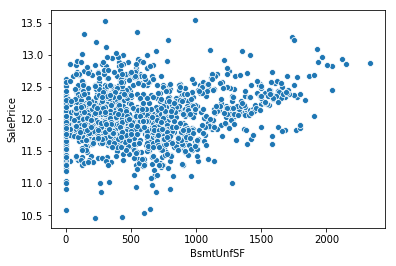

In [3]:
sns.scatterplot(house_source_data['BsmtUnfSF'], house_source_data['SalePrice'])

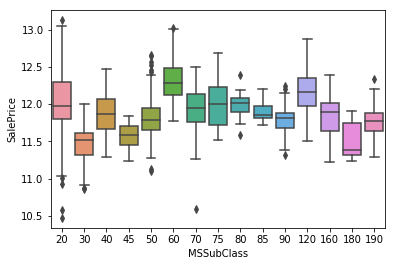

In [4]:
sns.boxplot(house_train_staging['MSSubClass'], house_source_data['SalePrice'])

In [5]:
lasso_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                             ('lasso', Lasso(selection='random', random_state=np.random.seed(seed)))])

lasso_param_grid = {'lasso__alpha' : [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03]}

lasso_grid = GridSearchCV(lasso_pipe, param_grid=lasso_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

lasso_grid.fit(house_train_staging.copy(), house_labels)

lasso_grid_pred = lasso_grid.best_estimator_.named_steps['lasso'].predict(house_train)

lasso_rmse = rmsle(house_labels, lasso_grid_pred)

lasso_grid_best = lasso_grid.best_estimator_.named_steps['lasso']

print('Results: {:,.8f} {:,.8f}'.format(-lasso_grid.best_score_, lasso_rmse))

Results: 0.01298672 0.00758181


/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [6]:
print('Results: {:,.8f} {:,.8f}'.format(-lasso_grid.best_score_, lasso_rmse))

Results: 0.01298672 0.00758181


In [7]:
lasso_grid.best_params_

{'lasso__alpha': 0.0001}

In [8]:
ridge_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                             ('rig', Ridge(random_state=np.random.seed(seed)))])

ridge_param_grid = {'rig__alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 0.1, 1, 2, 3, 4, 5]}

ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

ridge_grid.fit(house_train_staging.copy(), house_labels)

ridge_grid_pred = ridge_grid.best_estimator_.named_steps['rig'].predict(house_train)

ridge_rmse = rmsle(house_labels, ridge_grid_pred)

ridge_grid_best = ridge_grid.best_estimator_.named_steps['rig']

print('Results: {:,.8f} {:,.8f}'.format(-ridge_grid.best_score_, ridge_rmse))

Results: 0.01290531 0.00765669


In [9]:
print('Results: {:,.8f} {:,.8f}'.format(-ridge_grid.best_score_, ridge_rmse))

Results: 0.01290531 0.00765669


In [10]:
ridge_grid.best_params_

{'rig__alpha': 4}

In [11]:
elastic_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('elastic', ElasticNet(normalize=False,random_state=np.random.seed(seed)))])

elastic_param_grid = {'elastic__alpha' : [1e-05, 1e-04, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4],
                      'elastic__l1_ratio' : [0.2, 0.3, 0.4, 0.5, 0.85, 0.95, 0.9, 1.0]}

elastic_grid = GridSearchCV(elastic_pipe, param_grid=elastic_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

elastic_grid.fit(house_train_staging.copy(), house_labels)

elastic_grid_pred = elastic_grid.best_estimator_.named_steps['elastic'].predict(house_train)

elastic_rmse = rmsle(house_labels, elastic_grid_pred)

elastic_grid_best = elastic_grid.best_estimator_.named_steps['elastic']

print('Results: {:,.8f} {:8f}'.format(-elastic_grid.best_score_, elastic_rmse))

Results: 0.01239481 0.007884


/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [12]:
print('Results: {:8f} {:8f}'.format(-elastic_grid.best_score_, elastic_rmse))

Results: 0.012395 0.007884


In [13]:
elastic_grid.best_params_

{'elastic__alpha': 0.001, 'elastic__l1_ratio': 0.4}

In [14]:
from sklearn.svm import SVR

svm_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('svm', SVR(gamma='scale'))])

svm_param_grid =  {'svm__C' : [1e-7, 1e-6, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 2],
                   'svm__epsilon' : [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4]}

svm_grid = GridSearchCV(svm_pipe, param_grid=svm_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

svm_grid.fit(house_train_staging.copy(), house_labels)

svm_grid_pred = svm_grid.best_estimator_.named_steps['svm'].predict(house_train)

svm_rmse = rmsle(house_labels, svm_grid_pred)

svm_grid_best = svm_grid.best_estimator_.named_steps['svm']

print('Results: {:,.8f} {:8f}'.format(-svm_grid.best_score_, svm_rmse))

Results: 0.01493900 0.003954


In [15]:
print('Results: {:8f} {:8f}'.format(-svm_grid.best_score_, svm_rmse))

Results: 0.014939 0.003954


In [16]:
svm_grid.best_params_

{'svm__C': 1, 'svm__epsilon': 0.0001}

In [17]:
from sklearn.ensemble import RandomForestRegressor

rf_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                          ('rf', RandomForestRegressor(random_state=np.random.seed(seed), n_jobs=-1))])

rf_param_grid =  {'rf__max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 20, 25, 30, 35],
                   'rf__n_estimators' : [400, 300, 200, 500, 600, 700, 800, 900, 100],
                   'rf__max_features': ['sqrt']}

rf_grid = GridSearchCV(rf_pipe, param_grid=rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

rf_grid.fit(house_train_staging.copy(), house_labels)

rf_grid_pred = rf_grid.best_estimator_.named_steps['rf'].predict(house_train)

rf_rmse = rmsle(house_labels, rf_grid_pred)

rf_grid_best = rf_grid.best_estimator_.named_steps['rf']

print('Results: {:,.8f} {:.8f}'.format(-rf_grid.best_score_, rf_rmse))

Results: 0.01645222 0.00367411


In [18]:
print('Results: {:8f} {:8f}'.format(-rf_grid.best_score_, rf_rmse))

Results: 0.016452 0.003674


In [19]:
rf_grid.best_params_

{'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__n_estimators': 600}

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('gbr', GradientBoostingRegressor(random_state=np.random.seed(seed)))])

gbr_param_grid = {'gbr__max_depth' : [4, 5, 6],
                  'gbr__n_estimators' : [300, 350, 400],
                  'gbr__learning_rate' : [0.1, 0.2, 0.3],
                  'gbr__subsample' : [0.5, 0.6, 0.7]}

gbr_grid = GridSearchCV(gbr_pipe, param_grid=gbr_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

gbr_grid.fit(house_train_staging.copy(), house_labels)

gbr_grid_pred = gbr_grid.best_estimator_.named_steps['gbr'].predict(house_train)

gbr_rmse = rmsle(house_labels, gbr_grid_pred)

gbr_grid_best = gbr_grid.best_estimator_.named_steps['gbr']

print('Results: {:8f} {:8f}'.format(-gbr_grid.best_score_, gbr_rmse))

Results: 0.013774 0.002529


In [21]:
print('Results: {:8f} {:8f}'.format(-gbr_grid.best_score_, gbr_rmse))

Results: 0.013774 0.002529


In [22]:
gbr_grid.best_params_

{'gbr__learning_rate': 0.1,
 'gbr__max_depth': 4,
 'gbr__n_estimators': 300,
 'gbr__subsample': 0.5}

In [23]:
from sklearn.tree import DecisionTreeRegressor

dtr_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('dtr', DecisionTreeRegressor(random_state=np.random.seed(seed)))])

dtr_param_grid = {'dtr__max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                   'dtr__max_features': ['auto', 'sqrt', 'log2']}

dtr_grid = GridSearchCV(dtr_pipe, param_grid=dtr_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

dtr_grid.fit(house_train_staging.copy(), house_labels)

dtr_grid_pred = dtr_grid.best_estimator_.named_steps['dtr'].predict(house_train)

dtr_rmse = rmsle(house_labels, dtr_grid_pred)

# Store the tree to be used in Ada
tree_grid_cv = dtr_grid.best_estimator_.named_steps['dtr']

print('Results: {:8f} {:8f}'.format(-dtr_grid.best_score_, dtr_rmse))

Results: 0.030034 0.007720


In [24]:
print('Results: {:8f} {:8f}'.format(-dtr_grid.best_score_, dtr_rmse))

Results: 0.030034 0.007720


In [25]:
dtr_grid.best_params_

{'dtr__max_depth': 7, 'dtr__max_features': 'auto'}

In [26]:
from sklearn.ensemble import AdaBoostRegressor

ada_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('ada', AdaBoostRegressor(tree_grid_cv, random_state=np.random.seed(seed)))])

ada_param_grid = {'ada__n_estimators' : [300, 400, 450, 500],
                  'ada__learning_rate' : [0.8, 0.9, 1.0],
                  'ada__loss' : ['linear', 'square', 'exponential']}

ada_grid = GridSearchCV(ada_pipe, param_grid=ada_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

ada_grid.fit(house_train_staging.copy(), house_labels)

ada_grid_pred = ada_grid.best_estimator_.named_steps['ada'].predict(house_train)

ada_rmse = rmsle(house_labels, ada_grid_pred)

ada_grid_best = ada_grid.best_estimator_.named_steps['ada']

print('Results: {:8f} {:8f}'.format(-ada_grid.best_score_, ada_rmse))

Results: 0.016360 0.004601


In [27]:
print('Results: {:8f} {:8f}'.format(-ada_grid.best_score_, ada_rmse))

Results: 0.016360 0.004601


In [28]:
ada_grid.best_params_

{'ada__learning_rate': 1.0, 'ada__loss': 'square', 'ada__n_estimators': 500}

In [30]:
from mlxtend.regressor import StackingRegressor

# The StackingCVRegressor uses scikit-learn's check_cv
# internally, which doesn't support a random seed. Thus
# NumPy's random seed need to be specified explicitely for
# deterministic behavior

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

regressors = (lasso_grid_best, ridge_grid_best, svm_grid_best,
              gbr_grid_best, ada_grid_best)

stack = StackingRegressor(regressors=regressors,
                            meta_regressor=rf_grid_best).fit(house_train, house_labels)

stack_rmse = rmsle(house_labels, stack.predict(house_train))

print('5-fold cross validation scores:\n')

for regressors, label in zip([lasso_grid_best, ridge_grid_best, svm_grid_best,
              gbr_grid_best, ada_grid_best, stack], ['Lasso', 'Ridge', 'SVM', 'GBR', 'ADA', 
                                                'StackingRegressor']):
    scores = cross_val_score(regressors, house_train, house_labels, cv=5)
    print("R^2 Score: {:0.2f}% (+/-{:0.2f}%) {}".format(scores.mean(), scores.std(), label))
    
print(stack_rmse)

/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


5-fold cross validation scores:



/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

R^2 Score: 0.91% (+/-0.01%) Lasso
R^2 Score: 0.91% (+/-0.01%) Ridge
R^2 Score: 0.90% (+/-0.01%) SVM
R^2 Score: 0.90% (+/-0.01%) GBR
R^2 Score: 0.89% (+/-0.01%) ADA


/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

R^2 Score: 0.91% (+/-0.01%) StackingRegressor
0.0008343432679361114


In [31]:
print("R^2 Score: {:0.2f}% (+/-{:0.2f}%) {:0.8f}".format(scores.mean(), scores.std(), stack_rmse))

R^2 Score: 0.91% (+/-0.01%) 0.00083434


In [32]:
from sklearn.preprocessing import MinMaxScaler

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

nn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False), selected_categorical_onehot)
    ])

nn_train = nn_preprocessor.fit_transform(house_train_staging.copy())

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.losses import mean_squared_logarithmic_error

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(np.shape(house_train)[1], input_dim=np.shape(house_train)[1], kernel_initializer='normal',
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Using TensorFlow backend.


In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset

nn_estimator = KerasRegressor(build_fn=baseline_model, epochs=300, batch_size=128, verbose=1)

nn_estimator.fit(house_train, house_labels)

results = cross_val_score(nn_estimator, house_train, house_labels, cv=5, n_jobs =1)
score = nn_estimator.score(house_train, house_labels)
rmse = rmsle(house_labels, nn_estimator.predict(house_train))

print("Results: {:.2f}% ({:.2f}%) {:.5f} {:.5f}".format(results.mean()*100, results.std()*100, score, rmse))

Epoch 1/300


In [67]:
def kaggle_submission(estimator, test_set, test_source):
    """
    Create a csv to submit predictions to Kaggle.
    
    estimator: Sci-kit estimator used on training set.
    test_set: The transformed test set.
    test_source: The original test set, which contains the Id column.
    """
    submission = pd.DataFrame(index=test_source.index)
    submission['Id'] = pd.DataFrame(test_source['Id'])
    submission['SalePrice'] = pd.DataFrame(np.expm1(estimator.predict(test_set)), columns=['SalePrice'])
    
    return submission

predictions = kaggle_submission(stack, house_test_data, house_test)

In [68]:
predictions.to_csv('stack_reduced_with_featuring_submission.csv', index=False)